<a href="https://colab.research.google.com/github/ghazalna/Supplier-Performance-Evaluation-Clustering/blob/main/Supplier_Performance_Evaluation_%26_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supplier Performance Evaluation & Clustering**

## **Import Libraries**

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler  # for feature normalization
from sklearn.cluster import KMeans  # for clustering analysis
from sklearn.metrics import silhouette_score  # to evaluate clustering quality

In [2]:
# Display settings
pd.set_option('display.max_columns', None)  # display all columns in DataFrames
sns.set(style="whitegrid")  # set Seaborn plot style to white background with grid

## **Load Dataset**

In [3]:
# Step 2: Load Dataset
inventory_df = pd.read_csv("/content/drive/MyDrive/inventory_monitoring.csv")

In [4]:
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Product ID                     10000 non-null  int64 
 1   Store ID                       10000 non-null  int64 
 2   Stock Levels                   10000 non-null  int64 
 3   Supplier Lead Time (days)      10000 non-null  int64 
 4   Stockout Frequency             10000 non-null  int64 
 5   Reorder Point                  10000 non-null  int64 
 6   Expiry Date                    10000 non-null  object
 7   Warehouse Capacity             10000 non-null  int64 
 8   Order Fulfillment Time (days)  10000 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 703.3+ KB


In [5]:
inventory_df.head()

,Product ID,Store ID,Stock Levels,Supplier Lead Time (days),Stockout Frequency,Reorder Point,Expiry Date,Warehouse Capacity,Order Fulfillment Time (days)
0,9286,16,700,10,14,132,2024-01-15,1052,6
1,2605,60,82,11,1,127,2024-12-16,1262,9
2,2859,55,145,25,14,192,2024-04-30,1457,12
3,2374,24,151,17,6,19,2024-12-16,2944,3
4,7678,5,714,12,2,21,2024-08-05,3739,7


In [6]:
inventory_df['Product ID'].value_counts()

,count
Product ID,
2625,7
4211,6
5150,6
1281,6
8107,6
...,...
2394,1
6926,1
9456,1




*   **Stock Levels:**	Current stock per product/store
*   **Supplier Lead Time (days):**	Avg days supplier takes to deliver


*   **Stockout Frequency:**	How often the item runs out
*   **Reorder Point, Expiry Date:**	Reordering and expiration info


*   **Warehouse Capacity:**	How much space is available
*   **Order Fulfillment Time (days)**:	Time to complete an order








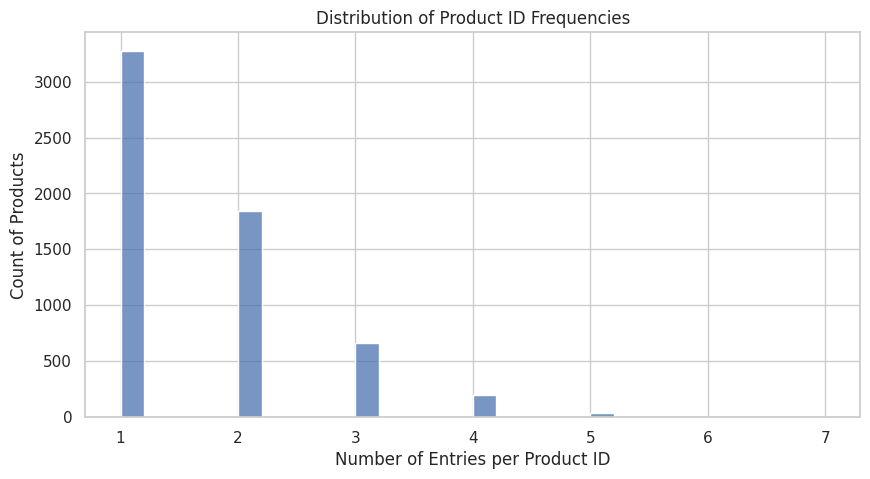

In [7]:
# Visualization: Check frequency of Product IDs (how many times each product appears)
plt.figure(figsize=(10, 5))
sns.histplot(inventory_df['Product ID'].value_counts(), bins=30, kde=False)
plt.title("Distribution of Product ID Frequencies")
plt.xlabel("Number of Entries per Product ID")
plt.ylabel("Count of Products")
plt.show()

**📊 1. Distribution of Product ID Frequencies:** This histogram shows how frequently each product appears in the dataset. The vast majority of products have only one or two records, indicating that most products were recorded just once or twice in the system. This is important because it affects how confidently we can evaluate product-level performance over time. For those products that appear multiple times, we can reliably calculate averages like lead time or fulfillment time — but for products with only one record, this kind of analysis would be very limited.

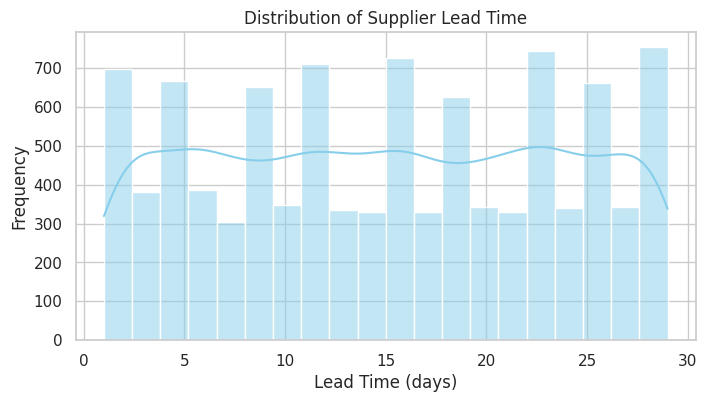

In [8]:
# Histogram of Supplier Lead Time
plt.figure(figsize=(8, 4))
sns.histplot(inventory_df['Supplier Lead Time (days)'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Supplier Lead Time")
plt.xlabel("Lead Time (days)")
plt.ylabel("Frequency")
plt.show()

⏱ **2. Distribution of Supplier Lead Time** :
The histogram of supplier lead times reveals a fairly uniform distribution across a wide range of values, from short lead times (just a few days) to close to 30 days. There is no single peak, suggesting that suppliers vary significantly in how fast they deliver goods. This reinforces the need to analyze suppliers individually, as some may require very different planning strategies than others to avoid stockouts or delays.

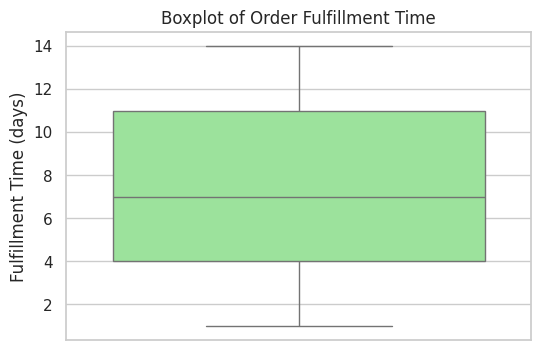

In [9]:
# Boxplot of Order Fulfillment Time
plt.figure(figsize=(6, 4))
sns.boxplot(y=inventory_df['Order Fulfillment Time (days)'], color='lightgreen')
plt.title("Boxplot of Order Fulfillment Time")
plt.ylabel("Fulfillment Time (days)")
plt.show()

**📦 3. Boxplot of Order Fulfillment Time**:
This boxplot highlights the spread of order fulfillment times. The median fulfillment time is around 7 days, with most values ranging between 3 and 12 days. However, there are a few outliers on both ends, including very fast and very slow fulfillments. These outliers may represent exceptional suppliers or potential issues (like delays or errors) and can be explored further to optimize the overall fulfillment process.

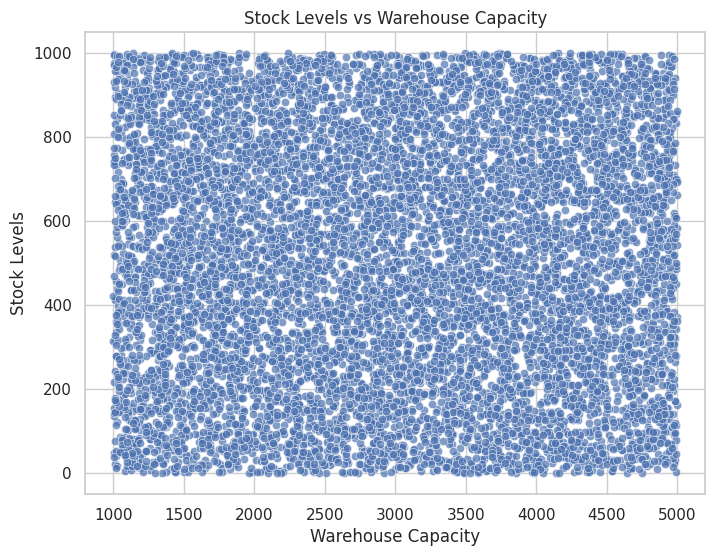

In [10]:
# Scatterplot: Stock Levels vs Warehouse Capacity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=inventory_df, x='Warehouse Capacity', y='Stock Levels', alpha=0.7)
plt.title("Stock Levels vs Warehouse Capacity")
plt.xlabel("Warehouse Capacity")
plt.ylabel("Stock Levels")
plt.show()

**🏭 4. Stock Levels vs Warehouse Capacity: **
This scatterplot examines the relationship between warehouse capacity and stock levels. Despite a wide range of warehouse capacities (from 1000 to nearly 5000 units), stock levels tend to stay within a narrower band. This suggests that many warehouses might not be operating at full capacity, possibly indicating inefficiencies or conservative stocking strategies. Identifying clusters of underutilized vs over-utilized facilities could support better inventory distribution decisions.

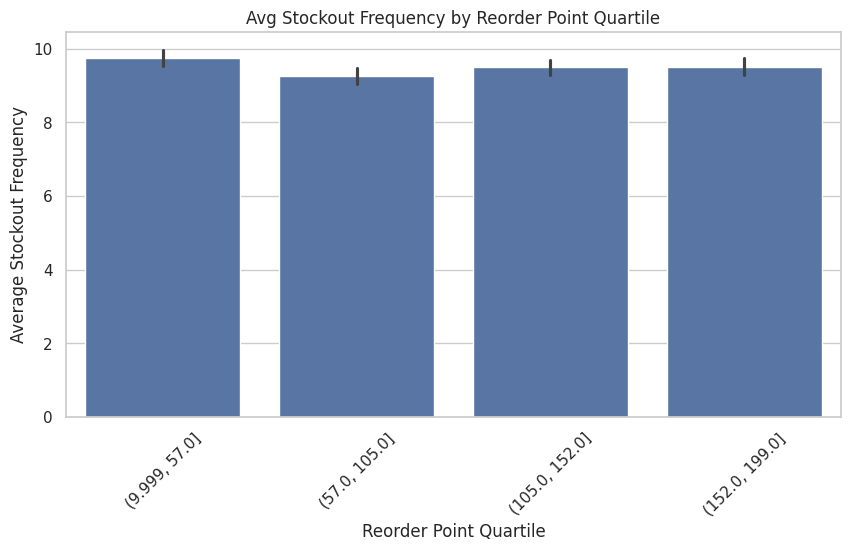

In [11]:
# Barplot of Average Stockout Frequency by Reorder Point Quartiles
inventory_df['Reorder Bin'] = pd.qcut(inventory_df['Reorder Point'], q=4)
plt.figure(figsize=(10, 5))
sns.barplot(x='Reorder Bin', y='Stockout Frequency', data=inventory_df, estimator=np.mean)
plt.title("Avg Stockout Frequency by Reorder Point Quartile")
plt.xlabel("Reorder Point Quartile")
plt.ylabel("Average Stockout Frequency")
plt.xticks(rotation=45)
plt.show()

**📉 5. Average Stockout Frequency by Reorder Point Quartile:**
This bar chart compares the average stockout frequency across different levels of reorder points (split into four quartiles). Interestingly, higher reorder points do not consistently result in lower stockouts, which challenges the assumption that increasing the reorder point always prevents shortages. This implies that reorder point alone may not be enough — and other variables like supplier reliability and lead time variability should also be factored into replenishment strategy.

## **Data Preprocessing**

In [17]:
# Step 3: Data Preprocessing
inventory_df['Expiry Date'] = pd.to_datetime(inventory_df['Expiry Date'])  # convert expiry date to datetime format

## **Feature Engineering**

In [18]:
# Step 4: Feature Engineering
supplier_features = inventory_df.copy()  # create a copy of the original dataframe for feature engineering

Since the dataset doesn't include a direct Supplier ID, I used Product ID as a proxy, assuming each product is sourced from a unique supplier. I then grouped the data by Product ID and calculated the mean of key performance metrics such as:

Supplier Lead Time (days)
Stockout Frequency
Order Fulfillment Time (days)
Warehouse Capacity
Stock Levels
This allowed me to evaluate supplier performance on a per-product basis, enabling further clustering and analysis based on these aggregated KPIs.

In [19]:
# Grouping by Supplier is not directly possible; assuming each Product ID is linked to a unique supplier.

supplier_perf = supplier_features.groupby('Product ID').agg({  # aggregate data by Product ID (proxy for supplier)
    'Supplier Lead Time (days)': 'mean',  # average lead time
    'Stockout Frequency': 'mean',  # average frequency of stockouts
    'Order Fulfillment Time (days)': 'mean',  # average fulfillment time
    'Warehouse Capacity': 'mean',  # average warehouse capacity
    'Stock Levels': 'mean'  # average stock levels
}).reset_index()

In [20]:
# Rename columns for readability
supplier_perf.columns = ['Product ID', 'Avg Lead Time', 'Stockout Freq', 'Fulfillment Time', 'Avg Warehouse Cap', 'Avg Stock']

In [21]:
supplier_perf

,Product ID,Avg Lead Time,Stockout Freq,Fulfillment Time,Avg Warehouse Cap,Avg Stock
0,1000,18.500000,9.500000,6.000000,1593.500000,682.000000
1,1001,18.333333,5.000000,7.666667,3411.333333,630.333333
2,1002,12.500000,3.000000,11.500000,4050.000000,371.000000
3,1003,17.000000,18.000000,6.000000,3912.000000,652.000000
4,1004,3.000000,18.000000,8.000000,4460.000000,998.000000
...,...,...,...,...,...,...
6026,9994,7.000000,8.333333,3.666667,2042.333333,295.666667
6027,9995,19.000000,8.000000,9.000000,3810.666667,626.333333
6028,9996,6.500000,7.000000,9.000000,3134.500000,275.000000
6029,9997,1.000000,1.000000,1.000000,2291.000000,177.000000


## **Clustering Suppliers**

In [22]:
# Step 5: Clustering Suppliers
features = supplier_perf.drop(columns=['Product ID'])  # remove non-numeric identifier before scaling
scaler = StandardScaler()  # initialize standard scaler to normalize data
X_scaled = scaler.fit_transform(features)  # apply normalization

In [23]:
# Determine optimal number of clusters using silhouette score
silhouette_scores = {}  # dictionary to store silhouette scores for different k
for k in range(2, 6):  # test cluster sizes from 2 to 5
    kmeans = KMeans(n_clusters=k, random_state=42)  # initialize KMeans
    labels = kmeans.fit_predict(X_scaled)  # fit model and get cluster labels
    silhouette_scores[k] = silhouette_score(X_scaled, labels)  # calculate silhouette score

In [24]:
# Fit KMeans with optimal k (let's choose k=3 as an example)
kmeans = KMeans(n_clusters=3, random_state=42)  # initialize KMeans with 3 clusters
supplier_perf['Cluster'] = kmeans.fit_predict(X_scaled)  # assign cluster labels to original data

## **Visualization**

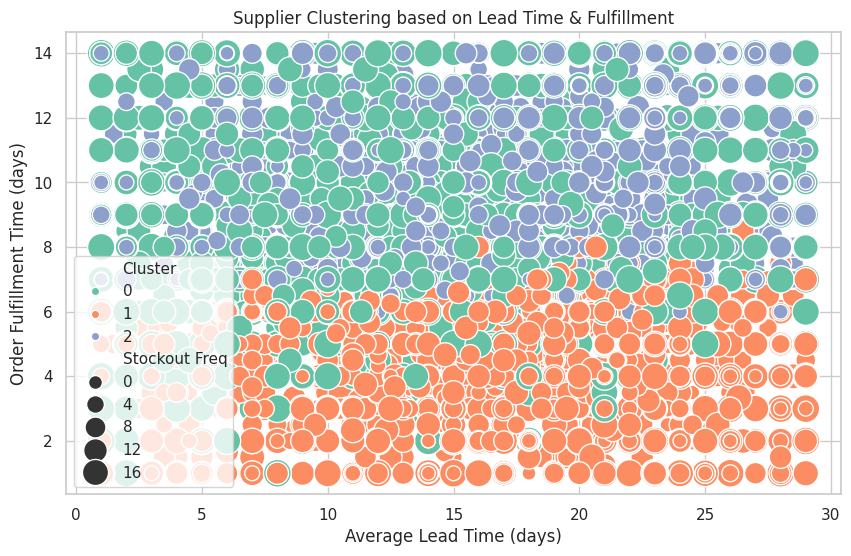

In [28]:
# Step 6: Visualization
plt.figure(figsize=(10, 6))  # set figure size for the plot
sns.scatterplot(data=supplier_perf, x='Avg Lead Time', y='Fulfillment Time', hue='Cluster', size='Stockout Freq', sizes=(100, 400), palette='Set2')  # plot suppliers colored by cluster
plt.title("Supplier Clustering based on Lead Time & Fulfillment")  # set plot title
plt.xlabel("Average Lead Time (days)")  # label x-axis
plt.ylabel("Order Fulfillment Time (days)")  # label y-axis
plt.legend()  # display legend
plt.show()  # show plot

#Cluster 0: Fast and reliable
#Cluster 1: Slow but consistent
#Cluster 2: Unpredictable and high stockout risk


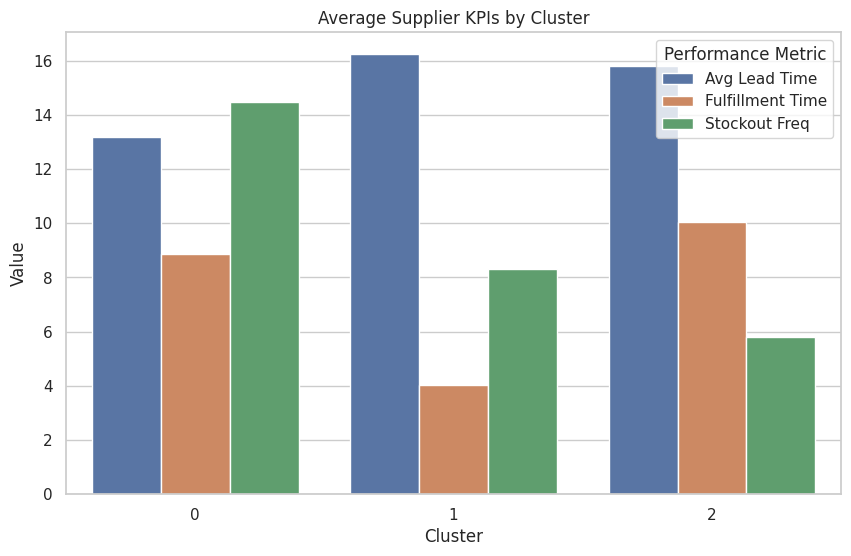

In [29]:
#Barplot: Average KPIs per Cluster
#This shows you how each cluster performs on average.
# Calculate average KPIs per cluster
cluster_summary = supplier_perf.groupby("Cluster")[['Avg Lead Time', 'Fulfillment Time', 'Stockout Freq']].mean().reset_index()

# Melt for easier plotting
melted = cluster_summary.melt(id_vars='Cluster', var_name='Metric', value_name='Value')

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Cluster', y='Value', hue='Metric')
plt.title("Average Supplier KPIs by Cluster")
plt.ylabel("Value")
plt.xlabel("Cluster")
plt.legend(title="Performance Metric")
plt.show()


<ipython-input-28-40b22e4573f6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=supplier_perf, x='Cluster', y='Fulfillment Time', palette='Set2')


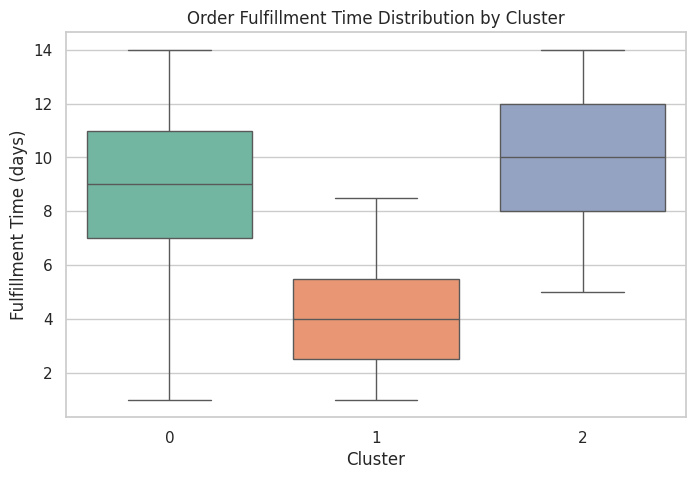

In [28]:
#Boxplot: Fulfillment Time per Cluster
#Quickly shows variability within each cluster.
plt.figure(figsize=(8, 5))
sns.boxplot(data=supplier_perf, x='Cluster', y='Fulfillment Time', palette='Set2')
plt.title("Order Fulfillment Time Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Fulfillment Time (days)")
plt.show()


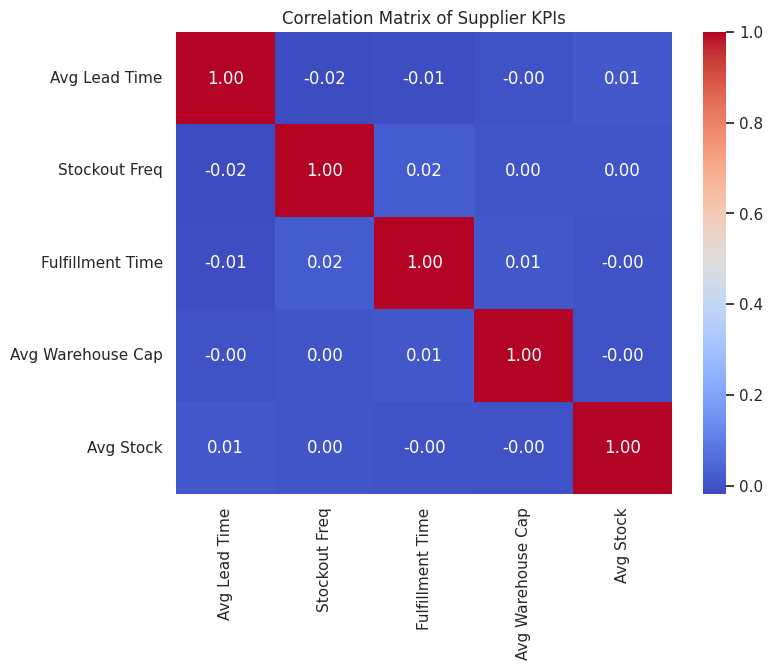

In [27]:
#Heatmap: Correlation Matrix of All KPIs
#Helps you understand which KPIs are related before clustering.
plt.figure(figsize=(8, 6))
sns.heatmap(supplier_perf.drop(columns=["Product ID", "Cluster"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Supplier KPIs")
plt.show()

## **Final Output Table**

In [29]:
# Step 7: Final Output Table
print(supplier_perf.sort_values(by='Cluster'))  # print the result sorted by cluster

      Product ID  Avg Lead Time  Stockout Freq  Fulfillment Time  \
6005        9965           22.0      19.000000          7.000000   
17          1026           18.0      19.000000          4.000000   
16          1025           12.0      14.333333          6.666667   
14          1022           12.0      17.000000          9.000000   
12          1015           22.0      17.500000         10.000000   
...          ...            ...            ...               ...   
6028        9996            6.5       7.000000          9.000000   
6013        9976           11.0       8.000000         11.000000   
6014        9978           18.0       0.000000          7.000000   
6015        9979           13.5       6.250000          9.250000   
6017        9981           28.0      12.000000         12.000000   

      Avg Warehouse Cap   Avg Stock  Cluster  
6005             3891.0  886.000000        0  
17               1707.0  586.000000        0  
16               3743.0  497.666667       

In [31]:
cluster_summary = supplier_perf.groupby("Cluster").agg({
    "Avg Lead Time": "mean",
    "Stockout Freq": "mean",
    "Fulfillment Time": "mean",
    "Avg Warehouse Cap": "mean",
    "Avg Stock": "mean",
    "Product ID": "count"  # to see how many products are in each cluster
}).rename(columns={"Product ID": "Number of Products"}).round(2)

display(cluster_summary)

#Cluster 0: Fast and reliable
#Cluster 1: Slow but consistent
#Cluster 2: Unpredictable and high stockout risk

,Avg Lead Time,Stockout Freq,Fulfillment Time,Avg Warehouse Cap,Avg Stock,Number of Products
Cluster,,,,,,
0,13.17,14.48,8.85,3023.13,512.46,1986
1,16.23,8.33,4.05,2892.84,505.76,2107
2,15.81,5.80,10.04,3080.11,493.80,1938
